# Naive Risk Budgeting Strategies between the PSP and GHP

In [39]:
import pandas as pd
import numpy as np
import edhec_risk_kit as erk
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
def bt_mix(r1, r2, allocator, **kwargs):
    """
    Runs a back test (simulation) of allocating between a two sets of returns
    r1 and r2 are T x N DataFrames or returns where T is the time step index and N is the number of scenarios.
    allocator is a function that takes two sets of returns and allocator specific parameters, and produces
    an allocation to the first portfolio (the rest of the money is invested in the GHP) as a T x 1 DataFrame
    REturns a T x N DataFrame of the retsulting N portfolio scenarios
    """
    if not r1.shape == r2.shape:
        raise ValueError("r1 and r2 need to be the same shape")
    weights = allocator(r1, r2, **kwargs)
    if not weights.shape == r1.shape:
        raise ValueError("Allocator returned weights that dont match r1")
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix

In [22]:
def fixedmix_allocator(r1, r2, w1, **kwargs):
    """
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarios
    PSP and GHP are T x N DataFrames that represent the returns of the PSP and GHP such that:
      each column is a scenario
      each row is the price for a timestep
    Returns an T x N DataFrame of PSP Weights
    """
    return pd.DataFrame(data=w1, index=r1.index, columns=r1.columns)

In [23]:
rates, zc_prices = erk.cir(10, 500, b=.03, r_0=.03)
price_10 = erk.bond_price(10, 100, .05, 12, rates)
price_30 = erk.bond_price(30, 100, .05, 12, rates)
rets_10 = erk.bond_total_return(price_10, 100, .05, 12)
rets_30 = erk.bond_total_return(price_30, 100, .05, 12)
rets_bonds = erk.bt_mix(rets_10, rets_30, allocator=erk.fixedmix_allocator, w1=.6)
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR,Sharpe Ratio,Max Drawdown
0,0.035847,0.00365,-0.353903,4.505875,-0.001143,-0.000377,1.55882,-0.000937


In [24]:
price_eq = erk.gbm(n_years=10, n_scenarios=500, mu=.07, sigma=.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()

In [26]:
rets_7030b = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.fixedmix_allocator, w1=.7)
rets_7030b_mean = rets_7030b.mean(axis='columns')
erk.summary_stats(pd.DataFrame(rets_7030b_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR,Sharpe Ratio,Max Drawdown
0,0.05788,0.00532,-0.12606,2.726501,-0.002123,-0.001582,5.100353,0.0


In [27]:
summaries = erk.summary_stats(rets_7030b)

In [28]:
summaries.head()

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR,Sharpe Ratio,Max Drawdown
0,0.046247,0.116432,-0.046091,3.403499,0.050885,0.070264,0.135667,-0.331567
1,0.084468,0.098572,-0.093935,2.897195,0.040240,0.053609,0.537706,-0.106899
2,0.046254,0.112125,0.200383,2.969273,0.046887,0.057364,0.140956,-0.214618
3,0.047545,0.110667,-0.075169,2.795470,0.048752,0.059067,0.154170,-0.362882
4,0.047520,0.118873,0.204711,2.434066,0.050128,0.056037,0.143298,-0.150755


In [29]:
summaries.mean()

Annualized Return          0.052389
Annualized Vol             0.107611
Skewness                   0.012681
Kurtosis                   2.966893
Cornish-Fisher VaR (5%)    0.046059
Historic CVaR              0.058134
Sharpe Ratio               0.203747
Max Drawdown              -0.212567
dtype: float64

In [30]:
def terminal_values(rets):
    """
    Returns the final values of a dollar at the end of the return period for each scenario
    """
    return (rets+1).prod()

In [32]:
pd.concat([
    erk.terminal_stats(rets_bonds, name="FI"),
    erk.terminal_stats(rets_eq, name="Eq"),
    erk.terminal_stats(rets_7030b, name="70/30")
], axis="columns")

,FI,Eq,70/30
mean,1.383405,1.921632,1.750100
std,0.112564,0.984155,0.599532
p_breach,NaN,0.052000,0.018000
e_short,NaN,0.174054,0.085578
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


/Users/jihoon/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jihoon/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jihoon/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

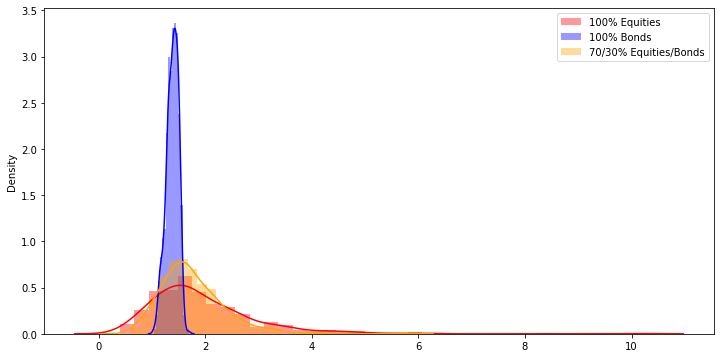

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.distplot(erk.terminal_values(rets_eq), color="red", label="100% Equities")
sns.distplot(erk.terminal_values(rets_bonds), color="blue", label="100% Bonds")
sns.distplot(erk.terminal_values(rets_7030b), color="orange", label="70/30% Equities/Bonds")
plt.legend();

# Glide Paths for Allocation

In [37]:
def glidepath_allocator(r1, r2, start_glide=1, end_glide=0):
    """
    Simulates a Target-Date-Fund style gradual move from r1 to r2
    """
    n_points = r1.shape[0]
    n_col = r1.shape[1]
    path = pd.Series(data=np.linspace(start_glide, end_glide, num=n_points))
    paths = pd.concat([path]*n_col, axis="columns")
    paths.index = r1.index
    paths.columns = r1.columns
    return paths

In [38]:
rets_g8020 = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.glidepath_allocator, start_glide=.8, end_glide=.2)
pd.concat([
    erk.terminal_stats(rets_bonds, name="FI"),
    erk.terminal_stats(rets_eq, name="Eq"),
    erk.terminal_stats(rets_7030b, name="70/30"),
    erk.terminal_stats(rets_g8020, name="Glide 80 to 20")
], axis="columns")

,FI,Eq,70/30,Glide 80 to 20
mean,1.383405,1.921632,1.750100,1.635788
std,0.112564,0.984155,0.599532,0.425891
p_breach,NaN,0.052000,0.018000,0.008000
e_short,NaN,0.174054,0.085578,0.049895
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN
